# Importing libraries and reading files

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import missingno

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/quantium/QVI_data.csv')
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


# Data Exploration

In [ ]:
# Number of rows and columns
df.shape

(264834, 12)

In [ ]:
# Datatype of the df columns
df.dtypes

LYLTY_CARD_NBR        int64
DATE                 object
STORE_NBR             int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
PACK_SIZE             int64
BRAND                object
LIFESTAGE            object
PREMIUM_CUSTOMER     object
dtype: object

In [ ]:
# Check for null values
df.isnull().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [ ]:
# Number of unique values
df.nunique()

LYLTY_CARD_NBR       72636
DATE                   364
STORE_NBR              272
TXN_ID              263125
PROD_NBR               114
PROD_NAME              114
PROD_QTY                 5
TOT_SALES              111
PACK_SIZE               21
BRAND                   21
LIFESTAGE                7
PREMIUM_CUSTOMER         3
dtype: int64

In [ ]:
# Find unique values for PROD_QTY, PACK_SIZE, BRAND, LIFESTAGE, PREMIUM_CUSTOMER
df['PROD_QTY'].unique(), df['PACK_SIZE'].unique(), df['BRAND'].unique(), df['LIFESTAGE'].unique(), df['PREMIUM_CUSTOMER'].unique()

(array([2, 1, 4, 3, 5]),
 array([175, 150, 210, 160, 165, 110, 330, 170, 300, 180, 135,  70, 220,
        190, 270,  90, 200, 134, 380, 125, 250]),
 array(['NATURAL', 'RRD', 'GRNWVES', 'WOOLWORTHS', 'CHEETOS', 'INFUZIONS',
        'DORITOS', 'OLD', 'SMITHS', 'KETTLE', 'CCS', 'TOSTITOS', 'COBS',
        'BURGER', 'THINS', 'TYRRELLS', 'CHEEZELS', 'TWISTIES', 'SUNBITES',
        'PRINGLES', 'FRENCH'], dtype=object),
 array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
        'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
        'RETIREES'], dtype=object),
 array(['Premium', 'Mainstream', 'Budget'], dtype=object))

# **Select control stores**

---

The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.

We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present
throughout the pre-trial period.

In [ ]:
# Add a new month ID column in the data with the format yyyymm
df['Month_id'] = [''.join(x.split('-')[0:2]) for x in df.DATE]
df.head(2)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Month_id
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809


In [ ]:
df['Month_id'].unique()

array(['201810', '201809', '201903', '201811', '201812', '201807',
       '201906', '201904', '201901', '201808', '201905', '201902'],
      dtype=object)

# Control store v/s other stores

In [ ]:
dfvs = df
dfvs.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Month_id
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


In [ ]:
dfvs = dfvs.loc[dfvs['Month_id']=='201902']
dfvs['Month_id'].unique()

array(['201902'], dtype=object)

In [ ]:
# Visual checks on trends based on the drivers
# Create a copy of pretrialmeasures as past_sales
#past_sales = pretrialmeasures
control_store = [155, 233, 237]
trial_store = [77, 86, 88]

# Create an empty list store_type
store_type = []

# For each store number in past_sales determine its type and save it in store_type
for i in dfvs['STORE_NBR']:
  if i in control_store:
    store_type.append('Control Store')
  elif i in trial_store:
    store_type.append('Trial Store')
  else:
    store_type.append('Other Store')

dfvs['store_type'] = store_type
dfvs.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Month_id,store_type
30,1024,2019-02-20,1,31,5,Natural Chip Compny SeaSalt175g,1,3.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201902,Other Store
42,1042,2019-02-12,1,46,63,Kettle 135g Swt Pot Sea Salt,1,4.2,135,KETTLE,YOUNG SINGLES/COUPLES,Premium,201902,Other Store
45,1043,2019-02-16,1,49,40,Thins Chips Seasonedchicken 175g,1,3.3,175,THINS,YOUNG FAMILIES,Budget,201902,Other Store


In [ ]:
dfvs['store_type'].unique()

array(['Other Store', 'Trial Store', 'Control Store'], dtype=object)

In [ ]:
dfvsn = dfvs.groupby(['DATE', 'store_type']).agg({'TOT_SALES': lambda sales:sales.mean()})
dfvsn.head()

TOT_SALES
DATE       store_type              
2019-02-01 Control Store   7.175000
           Other Store     7.302873
           Trial Store     7.600000
2019-02-02 Control Store   7.966667
           Other Store     7.378039

In [ ]:
dfvsn.reset_index('store_type', inplace=True)
dfvsn.head()

,store_type,TOT_SALES
DATE,,
2019-02-01,Control Store,7.175000
2019-02-01,Other Store,7.302873
2019-02-01,Trial Store,7.600000
2019-02-02,Control Store,7.966667
2019-02-02,Other Store,7.378039


In [ ]:
dfvsn.reset_index('DATE', inplace=True)
dfvsn.head()

,DATE,store_type,TOT_SALES
0,2019-02-01,Control Store,7.175000
1,2019-02-01,Other Store,7.302873
2,2019-02-01,Trial Store,7.600000
3,2019-02-02,Control Store,7.966667
4,2019-02-02,Other Store,7.378039


In [ ]:
# Create a new data frame containing 3 4 columns : transactionMonth, controlStores, trialStores, otherStores
other = dfvsn.loc[dfvsn['store_type'] == 'Other Store', ['DATE', 'TOT_SALES']]
other.set_index('DATE', inplace=True)
other.rename(columns={'TOT_SALES' : 'otherStores'}, inplace=True)
other.head()

control = dfvsn.loc[dfvsn['store_type'] == 'Control Store', ['DATE', 'TOT_SALES']]
control.set_index('DATE', inplace=True)
control.rename(columns={'TOT_SALES' : 'controlStores'}, inplace=True)
control.head()

trial = dfvsn.loc[dfvsn['store_type'] == 'Trial Store', ['DATE', 'TOT_SALES']]
trial.set_index('DATE', inplace=True)
trial.rename(columns={'TOT_SALES' : 'trialStores'}, inplace=True)
trial.head()

#others = past_sales.loc[past_sales['store_type'] == 'Other Store', ['transactionMonth', 'Total_sales']]
#others = pd.DataFrame(others.groupby('transactionMonth').agg({'Total_sales': lambda sales: sales.mean()}))
#others.rename(columns={'Total_sales' : 'otherStores'}, inplace=True)
#others

combinedplot = pd.concat([trial, control, other], axis=1)
combinedplot

,trialStores,controlStores,otherStores
DATE,,,
2019-02-01,7.600000,7.175000,7.302873
2019-02-02,7.753846,7.966667,7.378039
2019-02-03,7.734783,7.117647,7.345543
2019-02-04,7.242857,8.022222,7.571470
2019-02-05,8.169231,6.537500,7.420699
2019-02-06,6.175000,7.823077,7.383041
2019-02-07,7.707692,7.828571,7.401608
2019-02-08,7.525000,7.850000,7.350202
2019-02-09,6.970000,7.640000,7.506638


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 <a list of 28 Text major ticklabel objects>)

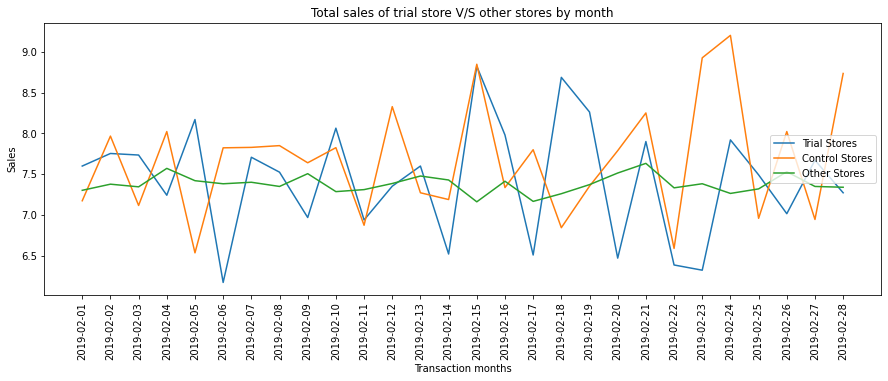

In [ ]:
# Now plot the above dataframe
combinedplot.index = combinedplot.index.astype(str)
plt.figure(figsize=(15,5))
plt.plot(combinedplot)
plt.xlabel('Transaction months')
plt.ylabel('Sales')
plt.title('Total sales of trial store V/S other stores by month')
plt.legend(['Trial Stores','Control Stores','Other Stores'], loc=5)
plt.xticks(rotation=90)


In [ ]:
dfvs2 = dfvs.loc[dfvs['Month_id']>'201902']
dfvs2.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Month_id,store_type


# continue

In [ ]:
# Next, we define the measure calculations to use during the analysis.
# For each store and month calculate total saless, number of customers,transactions per customer, chips per customer and the average price per unit.
df_ot = df.groupby(['STORE_NBR','Month_id']).agg({'TOT_SALES': lambda sales:sales.sum(),
                                     'LYLTY_CARD_NBR': lambda ncust: ncust.nunique(),
                                     'TXN_ID': lambda ntxn: ntxn.nunique(),
                                     'PROD_QTY': lambda qty: qty.sum()})
df_ot.head(3)

TOT_SALES  LYLTY_CARD_NBR  TXN_ID  PROD_QTY
STORE_NBR Month_id                                             
1         201807        206.9              49      52        62
          201808        176.1              42      43        54
          201809        278.8              59      62        75

In [ ]:
df_ot.columns = ['Total_sales', 'nCustomers', 'nTxn_per_cust', 'Avg_ppu']
df_ot.head(3)

Total_sales  nCustomers  nTxn_per_cust  Avg_ppu
STORE_NBR Month_id                                                 
1         201807          206.9          49             52       62
          201808          176.1          42             43       54
          201809          278.8          59             62       75

In [ ]:
df_ot[['nChips_per_Txn']] = df_ot['Avg_ppu']/df_ot['nTxn_per_cust']
df_ot['nTxn_per_cust'] = df_ot['nTxn_per_cust']/df_ot['nCustomers']
df_ot['Avg_ppu'] = df_ot['Total_sales']/df_ot['Avg_ppu']
df_ot.head()

Total_sales  nCustomers  ...   Avg_ppu  nChips_per_Txn
STORE_NBR Month_id                           ...                          
1         201807          206.9          49  ...  3.337097        1.192308
          201808          176.1          42  ...  3.261111        1.255814
          201809          278.8          59  ...  3.717333        1.209677
          201810          188.1          44  ...  3.243103        1.288889
          201811          192.6          46  ...  3.378947        1.212766

[5 rows x 5 columns]

In [ ]:
df_ot.index.get_level_values('STORE_NBR')

Int64Index([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            ...
            272, 272, 272, 272, 272, 272, 272, 272, 272, 272],
           dtype='int64', name='STORE_NBR', length=3169)

Next, lets filter to the pre-trial period and stores with full observation periods

In [ ]:
a = pd.pivot_table(data=df, index='STORE_NBR', columns='Month_id', values='TXN_ID', aggfunc='count')
a

Month_id,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0


In [ ]:
# Check if there are any missing values in the pivot table 'a'
a.isnull().sum()

Month_id
201807    6
201808    9
201809    8
201810    7
201811    8
201812    9
201901    9
201902    8
201903    7
201904    7
201905    9
201906    8
dtype: int64

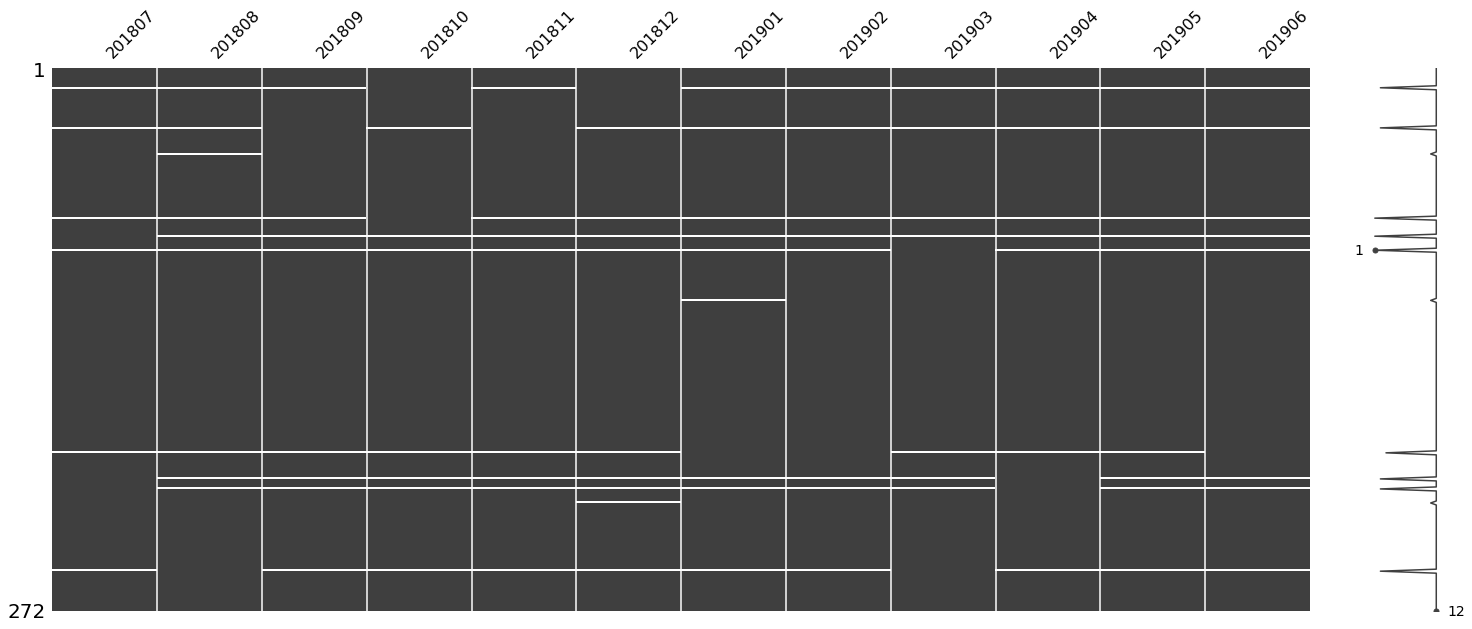

In [ ]:
missingno.matrix(a)

The above observations gives an idea of how many observations have null values, that means how many months for each store had no transactions at all

We move these null observation to a new list

In [ ]:
null_store = a[a.isnull().any(axis=1)].index.tolist()
null_store

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [ ]:
df_ot.reset_index(inplace=True)
df_ot.head()

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn
0,1,201807,206.9,49,1.061224,3.337097,1.192308
1,1,201808,176.1,42,1.023810,3.261111,1.255814
2,1,201809,278.8,59,1.050847,3.717333,1.209677
3,1,201810,188.1,44,1.022727,3.243103,1.288889
4,1,201811,192.6,46,1.021739,3.378947,1.212766


In [ ]:
df_ot.shape

(3169, 7)

Next we remove the null_store from df_ot

In [ ]:
df_ot = df_ot[~df_ot['STORE_NBR'].isin(null_store)]
df_ot.shape

(3120, 7)

In [ ]:
df_ot['Month_id']= pd.to_numeric(df_ot['Month_id'])
df_ot.dtypes

STORE_NBR           int64
Month_id            int64
Total_sales       float64
nCustomers          int64
nTxn_per_cust     float64
Avg_ppu           float64
nChips_per_Txn    float64
dtype: object

In [ ]:
# Create a ne dtaframe pretrialmeasures
pretrialmeasures = df_ot.loc[df_ot['Month_id'] < 201902, :]
len(pretrialmeasures)

1820

In [ ]:
pretrialmeasures.head()

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn
0,1,201807,206.9,49,1.061224,3.337097,1.192308
1,1,201808,176.1,42,1.023810,3.261111,1.255814
2,1,201809,278.8,59,1.050847,3.717333,1.209677
3,1,201810,188.1,44,1.022727,3.243103,1.288889
4,1,201811,192.6,46,1.021739,3.378947,1.212766


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.

In [ ]:
#  Create a function to calculate correlation for a measure, looping through each control store.
def calculateCorrelation(inputTable, metric, trial_store):
  output = pd.DataFrame({'Store1':[], 'Store2':[], 'Correlation':[]})
  a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
  a.reset_index(drop=True, inplace=True)
  storeNumber = inputTable['STORE_NBR'].unique()

  for i in storeNumber:
    b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
    b.reset_index(drop=True, inplace=True)
    output = output.append({'Store1': trial_store, 'Store2': i, 'Correlation': b.corr(a)}, ignore_index=True)
  return output

In [ ]:
# Create a function to calculate a standardised magnitude distance for a measure, looping through each control store 
def calculateMagnitudeDistance(inputTable, metric, trial_store):
  output = pd.DataFrame({'Store1':[], 'Store2':[], 'Magnitude':[]})
  a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
  a.reset_index(drop=True, inplace=True)
  storeNumber = inputTable['STORE_NBR'].unique()

  for i in storeNumber:
    b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
    b.reset_index(drop=True, inplace=True)
    c = abs(a-b)
    d = np.mean(1-(c-min(c))/(max(c)-min(c)))
    output = output.append({'Store1': trial_store, 'Store2': i, 'Magnitude': d}, ignore_index=True)
  return output


# **Selecting Control Stores for trial store 77**


---

Now let's use the functions to find the control stores.We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.


In [ ]:
# Compute correlation with trial store 77
trial_store = 77
corr_nSales = calculateCorrelation(pretrialmeasures, 'Total_sales', trial_store)
corr_nCustomers = calculateCorrelation(pretrialmeasures, 'nCustomers', trial_store)

In [ ]:
# Compute magnitude with trial store 77
magnitude_nSales = calculateMagnitudeDistance(pretrialmeasures, 'Total_sales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(pretrialmeasures, 'nCustomers', trial_store)

In [ ]:
corr_nSales.head()

,Store1,Store2,Correlation
0,77.0,1.0,0.075218
1,77.0,2.0,-0.263079
2,77.0,3.0,0.806644
3,77.0,4.0,-0.263300
4,77.0,5.0,-0.110652


In [ ]:
magnitude_nSales.head(), magnitude_nSales.shape

(   Store1  Store2  Magnitude
 0    77.0     1.0   0.408163
 1    77.0     2.0   0.590119
 2    77.0     3.0   0.522914
 3    77.0     4.0   0.644934
 4    77.0     5.0   0.516320, (260, 3))

We'll need to combine the all the scores calculated using our function to create a composite score to rank on. 

In [ ]:
# Create a combined score composed of correlation and magnitude, by first merging the correlations table with the magnitude table, for nSales
score_nSales = corr_nSales.merge(magnitude_nSales['Magnitude'], on=magnitude_nSales['Store2'], how='inner')
score_nSales.drop(columns=['key_0'], inplace=True, axis=1)
score_nSales.head()

,Store1,Store2,Correlation,Magnitude
0,77.0,1.0,0.075218,0.408163
1,77.0,2.0,-0.263079,0.590119
2,77.0,3.0,0.806644,0.522914
3,77.0,4.0,-0.263300,0.644934
4,77.0,5.0,-0.110652,0.516320


In [ ]:
# Similarly, create a combined score composed of correlation and magnitude, by first merging the correlations table with the magnitude table, for nCustomers
score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers['Magnitude'], on=magnitude_nCustomers['Store2'], how='inner')
score_nCustomers.drop(columns=['key_0'], inplace=True, axis=1)
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude
0,77.0,1.0,0.322168,0.663866
1,77.0,2.0,-0.572051,0.471429
2,77.0,3.0,0.834207,0.489796
3,77.0,4.0,-0.295639,0.498258
4,77.0,5.0,0.370659,0.512605


In [ ]:
# Add a new column calculating the weighted average for Score_nSales
corr_weight = 0.5
score_nSales['scoreNsales'] = corr_weight * score_nSales['Correlation'] + corr_weight * score_nSales['Magnitude']
score_nSales.head()

,Store1,Store2,Correlation,Magnitude,scoreNsales
0,77.0,1.0,0.075218,0.408163,0.241691
1,77.0,2.0,-0.263079,0.590119,0.163520
2,77.0,3.0,0.806644,0.522914,0.664779
3,77.0,4.0,-0.263300,0.644934,0.190817
4,77.0,5.0,-0.110652,0.516320,0.202834


In [ ]:
# Same for nCustomers
corr_weight = 0.5
score_nCustomers['scoreNcustomers'] = corr_weight * score_nCustomers['Correlation'] + corr_weight * score_nCustomers['Magnitude']
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude,scoreNcustomers
0,77.0,1.0,0.322168,0.663866,0.493017
1,77.0,2.0,-0.572051,0.471429,-0.050311
2,77.0,3.0,0.834207,0.489796,0.662002
3,77.0,4.0,-0.295639,0.498258,0.101310
4,77.0,5.0,0.370659,0.512605,0.441632


Now we have a score for each of total number of sales and number of customers.
Let's combine the two averages

In [ ]:
score_control = score_nSales[['Store1', 'Store2', 'scoreNsales']].merge(score_nCustomers['scoreNcustomers'], on=score_nCustomers['Store2'], how='inner')
score_control.drop(columns=['key_0'], axis=1, inplace=True)
score_control.head()

,Store1,Store2,scoreNsales,scoreNcustomers
0,77.0,1.0,0.241691,0.493017
1,77.0,2.0,0.163520,-0.050311
2,77.0,3.0,0.664779,0.662002
3,77.0,4.0,0.190817,0.101310
4,77.0,5.0,0.202834,0.441632


In [ ]:
score_control.set_index(['Store1','Store2'], inplace=True)
score_control.head(10)

scoreNsales  scoreNcustomers
Store1 Store2                              
77.0   1.0        0.241691         0.493017
       2.0        0.163520        -0.050311
       3.0        0.664779         0.662002
       4.0        0.190817         0.101310
       5.0        0.202834         0.441632
       6.0        0.332358         0.368428
       7.0        0.114897         0.039317
       8.0        0.157249         0.015601
       9.0       -0.144121        -0.087135
       10.0       0.215578         0.321395

Now create another column with average of both the scores

In [ ]:
score_control['finalControlScore'] = (score_control['scoreNsales'] + score_control['scoreNcustomers'])/2
score_control.head()

scoreNsales  scoreNcustomers  finalControlScore
Store1 Store2                                                 
77.0   1.0        0.241691         0.493017           0.367354
       2.0        0.163520        -0.050311           0.056604
       3.0        0.664779         0.662002           0.663390
       4.0        0.190817         0.101310           0.146064
       5.0        0.202834         0.441632           0.322233

The store with the highest score is then selected as the control store since it is most similar to the trial store.


In [ ]:
# Sort score_control in descending order based on finalcontrolscore
score_control.sort_values(by='finalControlScore', ascending=False)

scoreNsales  scoreNcustomers  finalControlScore
Store1 Store2                                                 
77.0   233.0      0.697290         0.816607           0.756949
       71.0       0.789497         0.663123           0.726310
       84.0       0.656972         0.715000           0.685986
       119.0      0.636046         0.729729           0.682887
       115.0      0.708347         0.645155           0.676751
...                    ...              ...                ...
       242.0     -0.121818        -0.046675          -0.084247
       186.0     -0.128806        -0.057268          -0.093037
       102.0     -0.102238        -0.119121          -0.110680
       9.0       -0.144121        -0.087135          -0.115628
       77.0            NaN              NaN                NaN

[260 rows x 3 columns]

The above tale shos that **Store Number 233** has the most similarity to trial store 77


---
# Now that we have found a control store, let's check visually if the drivers are
indeed similar in the period before the trial.

We'll look at total sales first.


In [ ]:
past_sales = pretrialmeasures
past_sales.head()

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn
0,1,201807,206.9,49,1.061224,3.337097,1.192308
1,1,201808,176.1,42,1.023810,3.261111,1.255814
2,1,201809,278.8,59,1.050847,3.717333,1.209677
3,1,201810,188.1,44,1.022727,3.243103,1.288889
4,1,201811,192.6,46,1.021739,3.378947,1.212766


In [ ]:
# Visual checks on trends based on the drivers
# Create a copy of pretrialmeasures as past_sales
past_sales = pretrialmeasures
control_store = 233

# Create an empty list store_type
store_type = []

# For each store number in past_sales determine its type and save it in store_type
for i in past_sales['STORE_NBR']:
  if i == trial_store:
    store_type.append('Trial Store')
  elif i == control_store:
    store_type.append('Control Store')
  else:
    store_type.append('Other Store')

past_sales['store_type'] = store_type
past_sales.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,store_type
0,1,201807,206.9,49,1.061224,3.337097,1.192308,Other Store
1,1,201808,176.1,42,1.023810,3.261111,1.255814,Other Store
2,1,201809,278.8,59,1.050847,3.717333,1.209677,Other Store
3,1,201810,188.1,44,1.022727,3.243103,1.288889,Other Store
4,1,201811,192.6,46,1.021739,3.378947,1.212766,Other Store


In [ ]:
past_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1820 entries, 0 to 3163
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   STORE_NBR       1820 non-null   int64  
 1   Month_id        1820 non-null   int64  
 2   Total_sales     1820 non-null   float64
 3   nCustomers      1820 non-null   int64  
 4   nTxn_per_cust   1820 non-null   float64
 5   Avg_ppu         1820 non-null   float64
 6   nChips_per_Txn  1820 non-null   float64
 7   store_type      1820 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 128.0+ KB


In [ ]:
# Create a ne column transactionMonth 
past_sales['transactionMonth'] = pd.to_datetime(past_sales['Month_id'].astype(str), format='%Y%m').dt.to_period('M')
past_sales.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,store_type,transactionMonth
0,1,201807,206.9,49,1.061224,3.337097,1.192308,Other Store,2018-07
1,1,201808,176.1,42,1.023810,3.261111,1.255814,Other Store,2018-08
2,1,201809,278.8,59,1.050847,3.717333,1.209677,Other Store,2018-09


In [ ]:
# Create a new data frame containing 3 4 columns : transactionMonth, controlStores, trialStores, otherStores
control = past_sales.loc[past_sales['store_type'] == 'Control Store', ['transactionMonth', 'Total_sales']]
control.set_index('transactionMonth', inplace=True)
control.rename(columns={'Total_sales' : 'controlStores'}, inplace=True)
control.head()

trial = past_sales.loc[past_sales['store_type'] == 'Trial Store', ['transactionMonth', 'Total_sales']]
trial.set_index('transactionMonth', inplace=True)
trial.rename(columns={'Total_sales' : 'trialStores'}, inplace=True)
trial.head()

others = past_sales.loc[past_sales['store_type'] == 'Other Store', ['transactionMonth', 'Total_sales']]
others = pd.DataFrame(others.groupby('transactionMonth').agg({'Total_sales': lambda sales: sales.mean()}))
others.rename(columns={'Total_sales' : 'otherStores'}, inplace=True)
others

combinedplot = pd.concat([trial, control, others], axis=1)
combinedplot

,trialStores,controlStores,otherStores
transactionMonth,,,
2018-07,296.8,290.7,638.004651
2018-08,255.5,285.9,610.223450
2018-09,225.2,228.6,620.198450
2018-10,204.5,185.7,635.314729
2018-11,245.3,211.6,618.864341
2018-12,267.3,279.8,648.453876
2019-01,204.4,177.5,628.684496


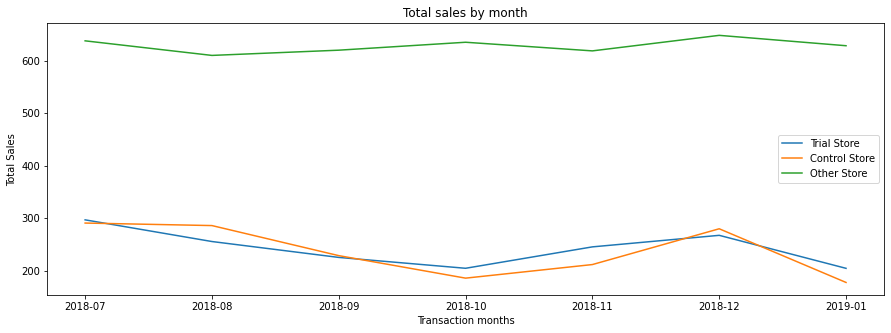

In [ ]:
# Now plot the above dataframe
combinedplot.index = combinedplot.index.astype(str)
plt.figure(figsize=(15,5))
plt.plot(combinedplot)
plt.xlabel('Transaction months')
plt.ylabel('Total Sales')
plt.title('Total sales by month')
plt.legend(['Trial Store', 'Control Store', 'Other Store'], loc=5)

Now, lets do the same for Customers

In [ ]:
# Create a new data frame containing 3 4 columns : transactionMonth, controlStores, trialStores, otherStores
ccontrol = past_sales.loc[past_sales['store_type'] == 'Control Store', ['transactionMonth', 'nCustomers']]
ccontrol.set_index('transactionMonth', inplace=True)
ccontrol.rename(columns={'nCustomers' : 'controlStores'}, inplace=True)
ccontrol.head()

ctrial = past_sales.loc[past_sales['store_type'] == 'Trial Store', ['transactionMonth', 'nCustomers']]
ctrial.set_index('transactionMonth', inplace=True)
ctrial.rename(columns={'nCustomers' : 'trialStores'}, inplace=True)
ctrial.head()

cothers = past_sales.loc[past_sales['store_type'] == 'Other Store', ['transactionMonth', 'nCustomers']]
cothers = pd.DataFrame(cothers.groupby('transactionMonth').agg({'nCustomers': lambda customer: customer.mean()}))
cothers.rename(columns={'nCustomers' : 'otherStores'}, inplace=True)
cothers

combinedplot = pd.concat([ctrial, ccontrol, cothers], axis=1)
combinedplot

,trialStores,controlStores,otherStores
transactionMonth,,,
2018-07,51,51,72.333333
2018-08,47,48,72.120155
2018-09,42,42,70.131783
2018-10,37,35,71.608527
2018-11,41,40,70.534884
2018-12,46,47,73.515504
2019-01,35,35,71.240310


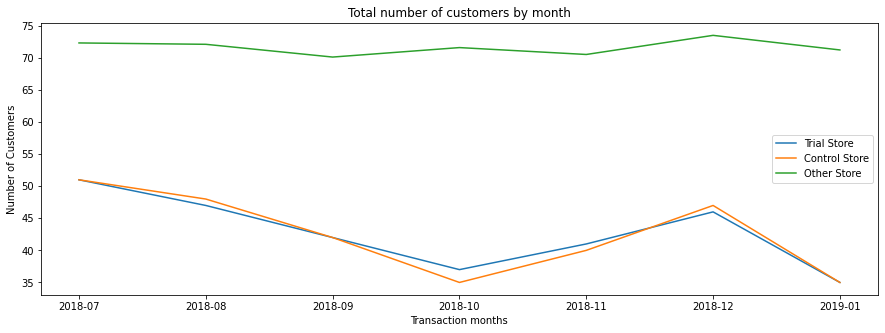

In [ ]:
# Now plot the above dataframe
combinedplot.index = combinedplot.index.astype(str)
plt.figure(figsize=(15,5))
plt.plot(combinedplot)
plt.xlabel('Transaction months')
plt.ylabel('Number of Customers')
plt.title('Total number of customers by month')
plt.legend(['Trial Store', 'Control Store', 'Other Store'], loc=5)

# Assessment of trial


---
The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.
We'll start with scaling the control store's sales to a level similar to control
for any differences between the two stores outside of the trial period.


In [ ]:
# Scale pre-trial control sales to match pre-trial trial store sales 
trial_sum = pretrialmeasures[pretrialmeasures['store_type'] == 'Trial Store']['Total_sales'].sum()
control_sum = pretrialmeasures[pretrialmeasures['store_type'] == 'Control Store']['Total_sales'].sum()
scalingFactorControlSales = trial_sum/control_sum
scalingFactorControlSales

1.023617303289553

In [ ]:
# Apply the scaling factor
scaledControlSales = df_ot
scaledControlSales.head()

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn
0,1,201807,206.9,49,1.061224,3.337097,1.192308
1,1,201808,176.1,42,1.023810,3.261111,1.255814
2,1,201809,278.8,59,1.050847,3.717333,1.209677
3,1,201810,188.1,44,1.022727,3.243103,1.288889
4,1,201811,192.6,46,1.021739,3.378947,1.212766


In [ ]:
# We filter the dataframe scaledControlSales to find only the control store (233)
scaledControlSales = scaledControlSales[scaledControlSales['STORE_NBR'] == control_store]
scaledControlSales

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn
2699,233,201807,290.7,51,1.058824,3.303409,1.629630
2700,233,201808,285.9,48,1.041667,3.573750,1.600000
2701,233,201809,228.6,42,1.071429,3.265714,1.555556
2702,233,201810,185.7,35,1.028571,3.316071,1.555556
2703,233,201811,211.6,40,1.025000,3.412903,1.512195
2704,233,201812,279.8,47,1.063830,3.730667,1.500000
2705,233,201901,177.5,35,1.000000,3.776596,1.342857
2706,233,201902,244.0,45,1.044444,3.485714,1.489362
2707,233,201903,199.1,40,1.025000,3.374576,1.439024
2708,233,201904,158.6,30,1.066667,3.447826,1.437500


In [ ]:
# In scaledControlSales, create a new column controlSales with value total sales * scalingFctorControlSales
scaledControlSales['controlSales'] = scaledControlSales['Total_sales'] * scalingFactorControlSales
scaledControlSales

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,controlSales
2699,233,201807,290.7,51,1.058824,3.303409,1.629630,297.565550
2700,233,201808,285.9,48,1.041667,3.573750,1.600000,292.652187
2701,233,201809,228.6,42,1.071429,3.265714,1.555556,233.998916
2702,233,201810,185.7,35,1.028571,3.316071,1.555556,190.085733
2703,233,201811,211.6,40,1.025000,3.412903,1.512195,216.597421
2704,233,201812,279.8,47,1.063830,3.730667,1.500000,286.408121
2705,233,201901,177.5,35,1.000000,3.776596,1.342857,181.692071
2706,233,201902,244.0,45,1.044444,3.485714,1.489362,249.762622
2707,233,201903,199.1,40,1.025000,3.374576,1.439024,203.802205
2708,233,201904,158.6,30,1.066667,3.447826,1.437500,162.345704


Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.


In [ ]:
scaledTrialSales = df_ot.loc[df_ot['STORE_NBR'] == trial_store, 'Total_sales']
scaledTrialSales.reset_index(drop=True, inplace=True)

percentageDiff = scaledControlSales[['Month_id', 'controlSales']]
percentageDiff.reset_index(drop=True, inplace=True)

# Concatinate both the dataframes
percentageDiff = pd.concat([percentageDiff, scaledTrialSales], axis=1)
percentageDiff.rename(columns={'Total_sales' : 'trial_sales'}, inplace=True)

percentageDiff


,Month_id,controlSales,trial_sales
0,201807,297.565550,296.8
1,201808,292.652187,255.5
2,201809,233.998916,225.2
3,201810,190.085733,204.5
4,201811,216.597421,245.3
5,201812,286.408121,267.3
6,201901,181.692071,204.4
7,201902,249.762622,235.0
8,201903,203.802205,278.5
9,201904,162.345704,263.5


In [ ]:
# Create a new column percentageDiff to calculate the percentage difference between scaled control sales and trial store sales
percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trial_sales)/percentageDiff.controlSales
percentageDiff.head()

,Month_id,controlSales,trial_sales,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516


Let's see if the difference is significant!

As our null hypothesis is that the trial period is the same as the pre-trial
period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period 


In [ ]:
from statistics import stdev

stdDev = stdev(percentageDiff.loc[percentageDiff['Month_id']<201902, 'percentageDiff'])
stdDev

0.04994076264142536

In [ ]:
# Note that there are 8 months in the pre-trial period
# hence 8 - 1 = 7 degrees of freedom
dof = 7

We will test with a null hypothesis of there being 0 difference between trial
and control stores.


In [ ]:
#  Calculate the t-values for the trial months
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0)/stdDev
percentageDiff.loc[(percentageDiff['Month_id']>201901) & (percentageDiff['Month_id']<201905), 'tValue']

7     1.183534
8     7.339116
9    12.476373
Name: tValue, dtype: float64

In [ ]:
#  Find the 95th percentile of the t distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.

from scipy.stats import t
t.isf(0.05, dof)

1.8945786050613054

We can observe that the t-value is much larger than the 95th percentile value of
the t-distribution for March and April - i.e. the increase in sales in the trial
store in March and April is statistically greater than in the control store.




---

Lets add a column 'transactionMonth' to scaledControlSales

In [ ]:
scaledControlSales['transactionMonth'] = pd.to_datetime(scaledControlSales['Month_id'].astype(str), format='%Y%m').dt.to_period('M')
scaledControlSales

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,controlSales,transactionMonth
2699,233,201807,290.7,51,1.058824,3.303409,1.629630,297.565550,2018-07
2700,233,201808,285.9,48,1.041667,3.573750,1.600000,292.652187,2018-08
2701,233,201809,228.6,42,1.071429,3.265714,1.555556,233.998916,2018-09
2702,233,201810,185.7,35,1.028571,3.316071,1.555556,190.085733,2018-10
2703,233,201811,211.6,40,1.025000,3.412903,1.512195,216.597421,2018-11
2704,233,201812,279.8,47,1.063830,3.730667,1.500000,286.408121,2018-12
2705,233,201901,177.5,35,1.000000,3.776596,1.342857,181.692071,2019-01
2706,233,201902,244.0,45,1.044444,3.485714,1.489362,249.762622,2019-02
2707,233,201903,199.1,40,1.025000,3.374576,1.439024,203.802205,2019-03
2708,233,201904,158.6,30,1.066667,3.447826,1.437500,162.345704,2019-04


# Let's create a more **visual version** of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.


In [ ]:
# Create a new dataframe from scaledControlSales containing transactionMonth and controlSales
controlSales = scaledControlSales.loc[:, ['transactionMonth', 'controlSales']]
controlSales.set_index('transactionMonth', inplace=True)
controlSales.rename(columns={'controlSales' : 'Control_Sales'}, inplace=True)
controlSales

,Control_Sales
transactionMonth,
2018-07,297.565550
2018-08,292.652187
2018-09,233.998916
2018-10,190.085733
2018-11,216.597421
2018-12,286.408121
2019-01,181.692071
2019-02,249.762622
2019-03,203.802205


In [ ]:
df_ot

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn
0,1,201807,206.9,49,1.061224,3.337097,1.192308
1,1,201808,176.1,42,1.023810,3.261111,1.255814
2,1,201809,278.8,59,1.050847,3.717333,1.209677
3,1,201810,188.1,44,1.022727,3.243103,1.288889
4,1,201811,192.6,46,1.021739,3.378947,1.212766
...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,4.346154,1.895833
3165,272,201903,442.3,50,1.060000,4.379208,1.905660
3166,272,201904,445.1,54,1.018519,4.239048,1.909091
3167,272,201905,314.6,34,1.176471,4.430986,1.775000


In [ ]:
# Create a new dataframe from trialSales from df_ot containing transactionMonth and Total_sales
trialSales = df_ot.loc[df_ot['STORE_NBR']==trial_store, ['Month_id', 'Total_sales']]
trialSales['Month_id'] = pd.to_datetime(trialSales['Month_id'].astype(str), format='%Y%m').dt.to_period('M')
trialSales.rename(columns={'Month_id' : 'transactionMonth', 'Total_sales' : 'Trial_Sales'}, inplace=True)
trialSales.set_index('transactionMonth', inplace=True)
trialSales

,Trial_Sales
transactionMonth,
2018-07,296.8
2018-08,255.5
2018-09,225.2
2018-10,204.5
2018-11,245.3
2018-12,267.3
2019-01,204.4
2019-02,235.0
2019-03,278.5


In [ ]:
# Combine controlSales and pastSales to trialAssessment
trialAssessment = pd.merge(trialSales, controlSales, left_index=True, right_index=True)
trialAssessment

,Trial_Sales,Control_Sales
transactionMonth,,
2018-07,296.8,297.565550
2018-08,255.5,292.652187
2018-09,225.2,233.998916
2018-10,204.5,190.085733
2018-11,245.3,216.597421
2018-12,267.3,286.408121
2019-01,204.4,181.692071
2019-02,235.0,249.762622
2019-03,278.5,203.802205


In [ ]:
# Create 2 new column containing the 5th percentile nad 95th percentile of Control_Sales
trialAssessment['Control5'] = trialAssessment['Control_Sales'] * (1 - stdDev * 2)
trialAssessment['Control95'] = trialAssessment['Control_Sales'] * (1 + stdDev * 2)
trialAssessment

,Trial_Sales,Control_Sales,Control5,Control95
transactionMonth,,,,
2018-07,296.8,297.565550,267.844249,327.286851
2018-08,255.5,292.652187,263.421640,321.882734
2018-09,225.2,233.998916,210.626747,257.371084
2018-10,204.5,190.085733,171.099680,209.071786
2018-11,245.3,216.597421,194.963341,238.231502
2018-12,267.3,286.408121,257.801241,315.015001
2019-01,204.4,181.692071,163.544390,199.839753
2019-02,235.0,249.762622,224.815950,274.709294
2019-03,278.5,203.802205,183.446130,224.158280


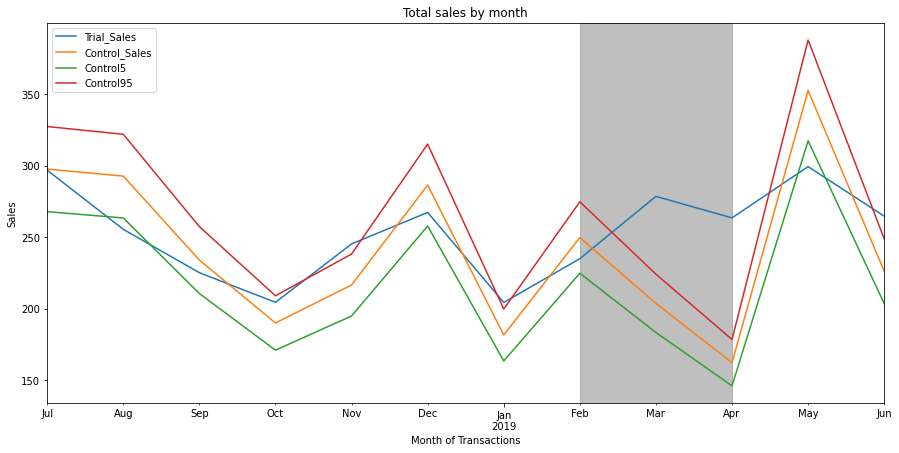

In [ ]:
# Plotting these in one nice graph
pd.DataFrame(trialAssessment).plot(figsize=(15,7))
plt.xlabel('Month of Transactions')
plt.ylabel('Sales')
plt.title('Total sales by month')
plt.axvspan('2019-02', '2019-04', color='grey', alpha=0.5)
plt.show()

The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial
months.

# Let's have a look at assessing this for number of customers as well. 
This would be a repeat of the steps before for total sales

---
Scale pre-trial control customers to match pre-trial trial store customers




In [ ]:
# Compute a scaling factor to align control store customer counts to our trial store.
trial_customers = pretrialmeasures.loc[pretrialmeasures['STORE_NBR']==trial_store, 'nCustomers'].sum()
control_customers = pretrialmeasures.loc[pretrialmeasures['STORE_NBR']==control_store, 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

1.0033557046979866

In [ ]:
# apply the scaling factor to control store customer counts
scaledControlCustomers = df_ot.loc[df_ot['STORE_NBR']==control_store]
scaledControlCustomers.head()

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn
2699,233,201807,290.7,51,1.058824,3.303409,1.629630
2700,233,201808,285.9,48,1.041667,3.573750,1.600000
2701,233,201809,228.6,42,1.071429,3.265714,1.555556
2702,233,201810,185.7,35,1.028571,3.316071,1.555556
2703,233,201811,211.6,40,1.025000,3.412903,1.512195


In [ ]:
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers']*scalingFactorCustomers
scaledControlCustomers.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,controlCustomers
2699,233,201807,290.7,51,1.058824,3.303409,1.629630,51.171141
2700,233,201808,285.9,48,1.041667,3.573750,1.600000,48.161074
2701,233,201809,228.6,42,1.071429,3.265714,1.555556,42.140940
2702,233,201810,185.7,35,1.028571,3.316071,1.555556,35.117450
2703,233,201811,211.6,40,1.025000,3.412903,1.512195,40.134228


In [ ]:
# Calculate the percentage difference between scaled control store customers and trial customers
percentageDiff = scaledControlCustomers[['Month_id', 'controlCustomers']]
percentageDiff.reset_index(drop=True, inplace=True)
percentageDiff.head()

,Month_id,controlCustomers
0,201807,51.171141
1,201808,48.161074
2,201809,42.140940
3,201810,35.117450
4,201811,40.134228


In [ ]:
# Concatenate with trial store 'nCustomers'
trialCustomers = df_ot.loc[df_ot['STORE_NBR']==trial_store, 'nCustomers']
trialCustomers.reset_index(drop=True, inplace=True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis=1)
percentageDiff.rename(columns={'nCustomers':'trialCustomers'}, inplace=True)
percentageDiff

,Month_id,controlCustomers,trialCustomers
0,201807,51.171141,51
1,201808,48.161074,47
2,201809,42.140940,42
3,201810,35.117450,37
4,201811,40.134228,41
5,201812,47.157718,46
6,201901,35.117450,35
7,201902,45.151007,45
8,201903,40.134228,50
9,201904,30.100671,47


In [ ]:
percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,Month_id,controlCustomers,trialCustomers,percentageDiff
0,201807,51.171141,51,0.003344
1,201808,48.161074,47,0.024108
2,201809,42.140940,42,0.003344
3,201810,35.117450,37,0.053607
4,201811,40.134228,41,0.021572
5,201812,47.157718,46,0.024550
6,201901,35.117450,35,0.003344
7,201902,45.151007,45,0.003344
8,201903,40.134228,50,0.245819
9,201904,30.100671,47,0.561427


Let's again see if the difference is significant visually!

As our null hypothesis is that the trial period is the same as the pre-trial
period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.

In [ ]:
stdDev = stdev(percentageDiff.loc[percentageDiff['Month_id']<201902, 'percentageDiff'])
stdDev

0.018240748558243945

In [ ]:
# Degree of freedom
dof = 7

In [ ]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# First, we create a new column 'tvalue'
percentageDiff['tvalue'] = (percentageDiff['percentageDiff'] - 0)/ stdDev
percentageDiff.loc[(percentageDiff['Month_id']>201901) & (percentageDiff['Month_id']<201905), 'tvalue']

7     0.183352
8    13.476388
9    30.778725
Name: tvalue, dtype: float64

In [ ]:
t.isf(0.05, dof)

1.8945786050613054

We see that 95th percentile is much lower than t-value for March and April

In [ ]:
# Visualising the same
# First we create 2 new columns control5 and control95 for 5th and 95th percentile of controlCustomer
percentageDiff['control5'] = percentageDiff['controlCustomers'] * (1 - stdDev*2)
percentageDiff['control95'] = percentageDiff['controlCustomers'] * (1 + stdDev*2)

percentageDiff

,Month_id,controlCustomers,trialCustomers,percentageDiff,tvalue,control5,control95
0,201807,51.171141,51,0.003344,0.183352,49.304341,53.037941
1,201808,48.161074,47,0.024108,1.321664,46.404086,49.918062
2,201809,42.140940,42,0.003344,0.183352,40.603575,43.678304
3,201810,35.117450,37,0.053607,2.938874,33.836313,36.398587
4,201811,40.134228,41,0.021572,1.182622,38.670071,41.598385
5,201812,47.157718,46,0.024550,1.345883,45.437334,48.878102
6,201901,35.117450,35,0.003344,0.183352,33.836313,36.398587
7,201902,45.151007,45,0.003344,0.183352,43.503830,46.798183
8,201903,40.134228,50,0.245819,13.476388,38.670071,41.598385
9,201904,30.100671,47,0.561427,30.778725,29.002554,31.198789


In [ ]:
# Create a new dataframe combineCustomer with control and trial customers and the 2 percentiles
combinedCustomer = percentageDiff[['Month_id', 'trialCustomers', 'controlCustomers', 'control5', 'control95']]
combinedCustomer

,Month_id,trialCustomers,controlCustomers,control5,control95
0,201807,51,51.171141,49.304341,53.037941
1,201808,47,48.161074,46.404086,49.918062
2,201809,42,42.140940,40.603575,43.678304
3,201810,37,35.117450,33.836313,36.398587
4,201811,41,40.134228,38.670071,41.598385
5,201812,46,47.157718,45.437334,48.878102
6,201901,35,35.117450,33.836313,36.398587
7,201902,45,45.151007,43.503830,46.798183
8,201903,50,40.134228,38.670071,41.598385
9,201904,47,30.100671,29.002554,31.198789


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


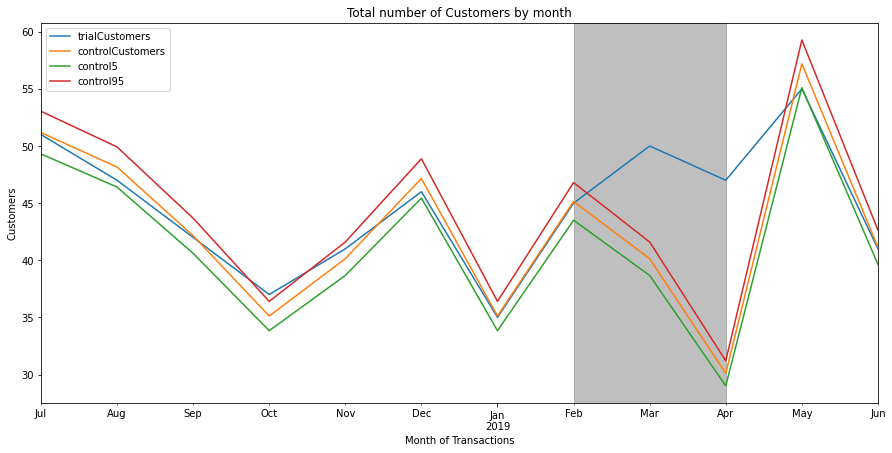

In [ ]:
# change Month_id to month year format and plot
combinedCustomer['Month_id'] = pd.to_datetime(combinedCustomer['Month_id'].astype(str), format='%Y%m').dt.to_period('M')
combinedCustomer.set_index('Month_id', inplace=True)

pd.DataFrame(combinedCustomer).plot(figsize=(15,7))
plt.xlabel('Month of Transactions')
plt.ylabel('Customers')
plt.title('Total number of Customers by month')
plt.axvspan('2019-02', '2019-04', color='grey', alpha=0.5)
plt.show()



---

---


Now we repeat all the above process for trial stores 86 and 88


# Selecting control store for trial 86

In [ ]:
# Corelation with trial store 86
trial_store = 86
corr_nSales = calculateCorrelation(pretrialmeasures, 'Total_sales', trial_store)
corr_nCustomers = calculateCorrelation(pretrialmeasures, 'nCustomers', trial_store)

# Magnitude with trial store 86
magnitude_nSales = calculateMagnitudeDistance(pretrialmeasures, 'Total_sales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(pretrialmeasures, 'nCustomers', trial_store)

In [ ]:
# Combine the scores for sales
score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis=1)
score_nSales

,Store1,Store2,Correlation,Magnitude
0,86.0,1.0,0.445632,0.488334
1,86.0,2.0,-0.403835,0.321131
2,86.0,3.0,-0.261284,0.507515
3,86.0,4.0,-0.039035,0.635654
4,86.0,5.0,0.235159,0.579835
...,...,...,...,...
255,86.0,268.0,-0.452182,0.291930
256,86.0,269.0,0.697055,0.480267
257,86.0,270.0,-0.730679,0.517014
258,86.0,271.0,0.527637,0.565665


In [ ]:
# Add another column with weigted average
score_nSales['scoreNsales'] = corr_weight * score_nSales['Correlation'] + (1 - corr_weight) * score_nSales['Magnitude']
score_nSales.head()

,Store1,Store2,Correlation,Magnitude,scoreNsales
0,86.0,1.0,0.445632,0.488334,0.466983
1,86.0,2.0,-0.403835,0.321131,-0.041352
2,86.0,3.0,-0.261284,0.507515,0.123116
3,86.0,4.0,-0.039035,0.635654,0.298309
4,86.0,5.0,0.235159,0.579835,0.407497


In [ ]:
# Combine the scores for customers
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis=1)
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude
0,86.0,1.0,0.485831,0.510204
1,86.0,2.0,-0.086161,0.428571
2,86.0,3.0,-0.353786,0.563025
3,86.0,4.0,-0.169608,0.537815
4,86.0,5.0,-0.253229,0.714286


In [ ]:
# Add nother column calculating weighted average
score_nCustomers['scoreNcustomers'] = corr_weight * score_nCustomers['Correlation'] + (1 - corr_weight) * score_nCustomers['Magnitude']
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude,scoreNcustomers
0,86.0,1.0,0.485831,0.510204,0.498018
1,86.0,2.0,-0.086161,0.428571,0.171205
2,86.0,3.0,-0.353786,0.563025,0.104620
3,86.0,4.0,-0.169608,0.537815,0.184103
4,86.0,5.0,-0.253229,0.714286,0.230528


In [ ]:
# Set index for both dataframes as Store1 and Store2
score_nSales.set_index(['Store1', 'Store2'], inplace=True)
score_nCustomers.set_index(['Store1', 'Store2'], inplace=True)

# Combine scoreNsales and scoreNcustomers to on edataframe
score_control = pd.concat([score_nSales['scoreNsales'], score_nCustomers['scoreNcustomers']], axis=1)
score_control.head()

scoreNsales  scoreNcustomers
Store1 Store2                              
86.0   1.0        0.466983         0.498018
       2.0       -0.041352         0.171205
       3.0        0.123116         0.104620
       4.0        0.298309         0.184103
       5.0        0.407497         0.230528

In [ ]:
# Add a new column calculating the average of both the columns
score_control['finalscore'] = (score_control['scoreNsales'] + score_control['scoreNcustomers'])/2
score_control.head()

scoreNsales  scoreNcustomers  finalscore
Store1 Store2                                          
86.0   1.0        0.466983         0.498018    0.482500
       2.0       -0.041352         0.171205    0.064927
       3.0        0.123116         0.104620    0.113868
       4.0        0.298309         0.184103    0.241206
       5.0        0.407497         0.230528    0.319013

In [ ]:
# Stores with highest final scores
score_control.sort_values(by='finalscore', ascending=False).head()

scoreNsales  scoreNcustomers  finalscore
Store1 Store2                                          
86.0   155.0      0.808106         0.733343    0.770724
       109.0      0.697120         0.742532    0.719826
       114.0      0.631393         0.663384    0.647389
       225.0      0.601841         0.684356    0.643099
       138.0      0.593296         0.660565    0.626930

From the above table we can observe that stor 155 has the highest final score and matches most with store 86

In [ ]:
control_store = 155

In [ ]:
# Create new dataframe pastsales and add a column 'storetype'
past_sales = pretrialmeasures

store_type = []

for i in past_sales['STORE_NBR']:
  if i == trial_store:
    store_type.append('Trial Store')
  elif i == control_store:
    store_type.append('Control Store')
  else:
    store_type.append('Other Store')

past_sales['store_type'] = store_type

past_sales.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,store_type,transactionMonth
0,1,201807,206.9,49,1.061224,3.337097,1.192308,Other Store,2018-07
1,1,201808,176.1,42,1.023810,3.261111,1.255814,Other Store,2018-08
2,1,201809,278.8,59,1.050847,3.717333,1.209677,Other Store,2018-09
3,1,201810,188.1,44,1.022727,3.243103,1.288889,Other Store,2018-10
4,1,201811,192.6,46,1.021739,3.378947,1.212766,Other Store,2018-11


In [ ]:
# For sales visualisation create relevant dataframes
controlsalesplot = past_sales.loc[past_sales['store_type'] == 'Control Store', ['transactionMonth', 'Total_sales']]
controlsalesplot.set_index('transactionMonth', inplace=True)
controlsalesplot.rename(columns={'Total_sales' : 'Control Sales'}, inplace=True)

trialsalesplot = past_sales.loc[past_sales['store_type'] == 'Trial Store', ['transactionMonth', 'Total_sales']]
trialsalesplot.set_index('transactionMonth', inplace=True)
trialsalesplot.rename(columns={'Total_sales' : 'Trial Sales'}, inplace=True)

othersalesplot = past_sales.loc[past_sales['store_type'] == 'Other Store', ['transactionMonth', 'Total_sales']]
othersalesplot = pd.DataFrame(othersalesplot.groupby('transactionMonth').agg({'Total_sales': lambda sales:sales.mean()}))
othersalesplot.rename(columns={'Total_sales' : 'Other Sales'}, inplace=True)

# Combiine the three daaframe
combinedplot = pd.concat([controlsalesplot, trialsalesplot, othersalesplot], axis=1)
combinedplot.head()

,Control Sales,Trial Sales,Other Sales
transactionMonth,,,
2018-07,924.6,892.20,633.239922
2018-08,782.7,764.05,606.326744
2018-09,1014.4,914.60,614.480620
2018-10,963.8,948.40,629.415504
2018-11,898.8,918.00,613.593411


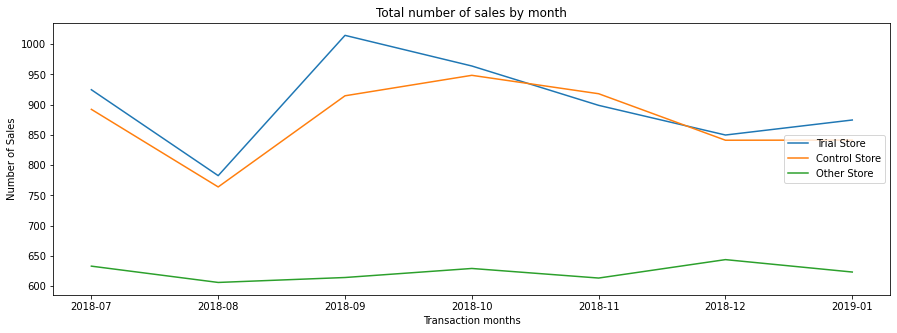

In [ ]:
combinedplot.index = combinedplot.index.astype(str)
plt.figure(figsize=(15,5))
plt.plot(combinedplot)
plt.xlabel('Transaction months')
plt.ylabel('Number of Sales')
plt.title('Total number of sales by month')
plt.legend(['Trial Store', 'Control Store', 'Other Store'], loc=5)



---

---
Lets do the same for Customers



In [ ]:
# For customers visualisation create relevant dataframes
controlcustomerplot = past_sales.loc[past_sales['store_type'] == 'Control Store', ['transactionMonth', 'nCustomers']]
controlcustomerplot.set_index('transactionMonth', inplace=True)
controlcustomerplot.rename(columns={'nCustomers' : 'Control Store'}, inplace=True)

trialcustomerplot = past_sales.loc[past_sales['store_type'] == 'Trial Store', ['transactionMonth', 'nCustomers']]
trialcustomerplot.set_index('transactionMonth', inplace=True)
trialcustomerplot.rename(columns={'nCustomers' : 'Trial Store'}, inplace=True)

othercustomerplot = past_sales.loc[past_sales['store_type'] == 'Other Store', ['transactionMonth', 'nCustomers']]
othercustomerplot = pd.DataFrame(othercustomerplot.groupby('transactionMonth').agg({'nCustomers': lambda cust:cust.mean()}))
othercustomerplot.rename(columns={'nCustomers' : 'Other Store'}, inplace=True)

# Combiine the three daaframe
combinedplot = pd.concat([controlcustomerplot, trialcustomerplot, othercustomerplot], axis=1)
combinedplot.head()

,Control Store,Trial Store,Other Store
transactionMonth,,,
2018-07,101,99,71.953488
2018-08,91,94,71.771318
2018-09,103,103,69.658915
2018-10,108,109,71.046512
2018-11,101,100,70.069767


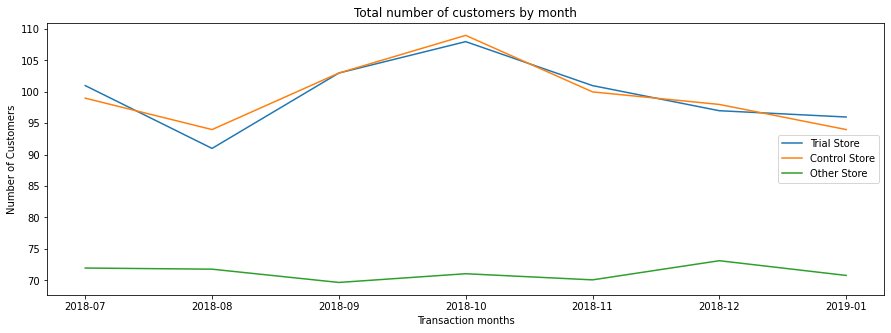

In [ ]:
combinedplot.index = combinedplot.index.astype(str)
plt.figure(figsize=(15,5))
plt.plot(combinedplot)
plt.xlabel('Transaction months')
plt.ylabel('Number of Customers')
plt.title('Total number of customers by month')
plt.legend(['Trial Store', 'Control Store', 'Other Store'], loc=5)

# Assessment for trial 

In [ ]:
# scaling factor for control store
trial_sum = past_sales.loc[past_sales['store_type'] == 'Trial Store', 'Total_sales'].sum()
control_sum = past_sales.loc[past_sales['store_type'] == 'Control Store', 'Total_sales'].sum()
scalingfactorsales = trial_sum/control_sum
scalingfactorsales

0.9700651481287743

In [ ]:
# Create a new dataframe 'scaledControlSales'
scaledControlSales = df_ot
scaledControlSales.head()

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn
0,1,201807,206.9,49,1.061224,3.337097,1.192308
1,1,201808,176.1,42,1.023810,3.261111,1.255814
2,1,201809,278.8,59,1.050847,3.717333,1.209677
3,1,201810,188.1,44,1.022727,3.243103,1.288889
4,1,201811,192.6,46,1.021739,3.378947,1.212766


In [ ]:
# FIlter for only control stores
scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR']==control_store]
scaledControlSales

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn
1793,155,201807,924.60,101,1.217822,3.698400,2.032520
1794,155,201808,782.70,91,1.307692,3.417904,1.924370
1795,155,201809,1014.40,103,1.398058,3.497931,2.013889
1796,155,201810,963.80,108,1.259259,3.543382,2.000000
1797,155,201811,898.80,101,1.316832,3.328889,2.030075
1798,155,201812,849.80,97,1.237113,3.511570,2.016667
1799,155,201901,874.60,96,1.302083,3.470635,2.016000
1800,155,201902,891.20,95,1.315789,3.508661,2.032000
1801,155,201903,804.40,94,1.255319,3.351667,2.033898
1802,155,201904,844.60,99,1.212121,3.490083,2.016667


In [ ]:
#Create controlSales column
scaledControlSales['controlSales'] = scaledControlSales['Total_sales']*scalingfactorsales
scaledControlSales.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,controlSales
1793,155,201807,924.6,101,1.217822,3.698400,2.032520,896.922236
1794,155,201808,782.7,91,1.307692,3.417904,1.924370,759.269991
1795,155,201809,1014.4,103,1.398058,3.497931,2.013889,984.034086
1796,155,201810,963.8,108,1.259259,3.543382,2.000000,934.948790
1797,155,201811,898.8,101,1.316832,3.328889,2.030075,871.894555


In [ ]:
# Create percentageDiff dataframe
percentageDiff = scaledControlSales[['Month_id', 'controlSales']]
percentageDiff.reset_index(drop=True, inplace=True)

# Trial store total sales in a dataframe and then concat both
trialSales = df_ot.loc[df_ot['STORE_NBR'] == trial_store, 'Total_sales']
trialSales.reset_index(drop=True, inplace=True)

percentageDiff = pd.concat([percentageDiff, trialSales], axis=1)
percentageDiff.rename(columns={'Total_sales':'trialSales'}, inplace=True)
percentageDiff.head()

,Month_id,controlSales,trialSales
0,201807,896.922236,892.20
1,201808,759.269991,764.05
2,201809,984.034086,914.60
3,201810,934.948790,948.40
4,201811,871.894555,918.00


In [ ]:
# Calculate percentage Difference in another column
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['trialSales']) / percentageDiff['controlSales']
percentageDiff.head()

,Month_id,controlSales,trialSales,percentageDiff
0,201807,896.922236,892.20,0.005265
1,201808,759.269991,764.05,0.006296
2,201809,984.034086,914.60,0.070561
3,201810,934.948790,948.40,0.014387
4,201811,871.894555,918.00,0.052880


In [ ]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period. Let's take the standard deviation based on the scaled percentage difference in the pre-trial period
stdDev = stdev(percentageDiff.loc[percentageDiff['Month_id']<201902, 'percentageDiff'])
stdDev

0.02583395285477237



---



---
VISUALISATION


In [ ]:
scaledControlSales['transactionMonth'] = pd.to_datetime(scaledControlSales['Month_id'].astype(str), format='%Y%m').dt.to_period('M')
scaledControlSales

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,controlSales,transactionMonth
1793,155,201807,924.60,101,1.217822,3.698400,2.032520,896.922236,2018-07
1794,155,201808,782.70,91,1.307692,3.417904,1.924370,759.269991,2018-08
1795,155,201809,1014.40,103,1.398058,3.497931,2.013889,984.034086,2018-09
1796,155,201810,963.80,108,1.259259,3.543382,2.000000,934.948790,2018-10
1797,155,201811,898.80,101,1.316832,3.328889,2.030075,871.894555,2018-11
1798,155,201812,849.80,97,1.237113,3.511570,2.016667,824.361363,2018-12
1799,155,201901,874.60,96,1.302083,3.470635,2.016000,848.418979,2019-01
1800,155,201902,891.20,95,1.315789,3.508661,2.032000,864.522060,2019-02
1801,155,201903,804.40,94,1.255319,3.351667,2.033898,780.320405,2019-03
1802,155,201904,844.60,99,1.212121,3.490083,2.016667,819.317024,2019-04


In [ ]:
controlSales = scaledControlSales.loc[:, ['transactionMonth', 'controlSales']]
controlSales.set_index('transactionMonth', inplace=True)
controlSales.rename(columns={'controlSales' : 'Control Sales'}, inplace=True)
controlSales.head()

,Control Sales
transactionMonth,
2018-07,896.922236
2018-08,759.269991
2018-09,984.034086
2018-10,934.948790
2018-11,871.894555


In [ ]:
df_ot['transactionMonth'] = pd.to_datetime(df_ot['Month_id'].astype(str), format='%Y%m').dt.to_period('M')
df_ot.head()

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,transactionMonth
0,1,201807,206.9,49,1.061224,3.337097,1.192308,2018-07
1,1,201808,176.1,42,1.023810,3.261111,1.255814,2018-08
2,1,201809,278.8,59,1.050847,3.717333,1.209677,2018-09
3,1,201810,188.1,44,1.022727,3.243103,1.288889,2018-10
4,1,201811,192.6,46,1.021739,3.378947,1.212766,2018-11


In [ ]:
trialSales = df_ot.loc[df_ot['STORE_NBR'] == trial_store, ['transactionMonth', 'Total_sales']]
trialSales.set_index('transactionMonth', inplace=True)
trialSales.rename(columns={'Total_sales' : 'Trial Sales'}, inplace=True)
trialSales.head()

,Trial Sales
transactionMonth,
2018-07,892.20
2018-08,764.05
2018-09,914.60
2018-10,948.40
2018-11,918.00


In [ ]:
combinesales = pd.concat([controlSales, trialSales], axis=1)
combinesales['control5'] = combinesales['Control Sales'] * (1 - stdDev*2)
combinesales['combine95'] = combinesales['Control Sales'] * (1 + stdDev*2)
combinesales.head()

,Control Sales,Trial Sales,control5,combine95
transactionMonth,,,,
2018-07,896.922236,892.20,850.580142,943.264329
2018-08,759.269991,764.05,720.040101,798.499882
2018-09,984.034086,914.60,933.191106,1034.877067
2018-10,934.948790,948.40,886.641944,983.255636
2018-11,871.894555,918.00,826.845589,916.943521


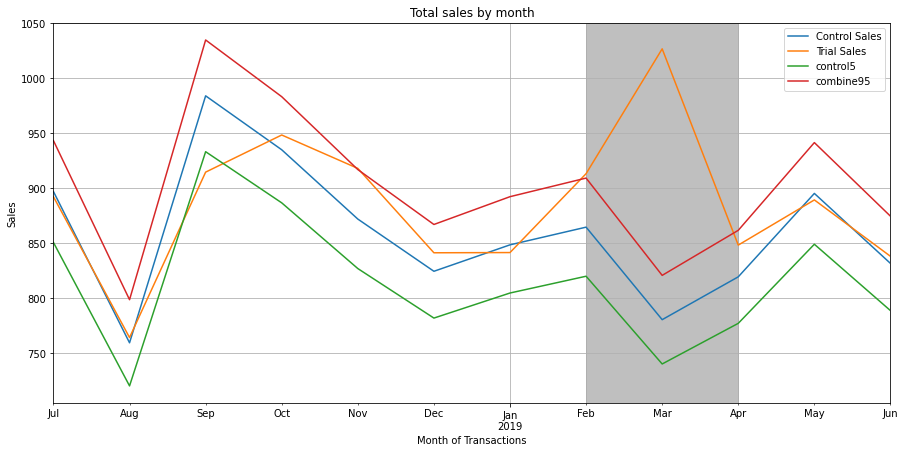

In [ ]:
# Plotting these in one nice graph
pd.DataFrame(combinesales).plot(figsize=(15,7))
plt.xlabel('Month of Transactions')
plt.ylabel('Sales')
plt.title('Total sales by month')
plt.axvspan('2019-02', '2019-04', color='grey', alpha=0.5)
plt.grid()
plt.show()

The results show that the trial in store 86 is not significantly different to 
its control store in the trial period, since the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

---

---

Lets work with Customers next.



In [ ]:
# Find scaling factor
trial_customers = pretrialmeasures.loc[pretrialmeasures['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = pretrialmeasures.loc[pretrialmeasures['store_type'] == 'Control Store', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

1.0

In [ ]:
scaledControlCustomers = df_ot
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == control_store]
scaledControlCustomers.head()

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,transactionMonth
1793,155,201807,924.6,101,1.217822,3.698400,2.032520,2018-07
1794,155,201808,782.7,91,1.307692,3.417904,1.924370,2018-08
1795,155,201809,1014.4,103,1.398058,3.497931,2.013889,2018-09
1796,155,201810,963.8,108,1.259259,3.543382,2.000000,2018-10
1797,155,201811,898.8,101,1.316832,3.328889,2.030075,2018-11


In [ ]:
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,transactionMonth,controlCustomers
1793,155,201807,924.6,101,1.217822,3.698400,2.032520,2018-07,101.0
1794,155,201808,782.7,91,1.307692,3.417904,1.924370,2018-08,91.0
1795,155,201809,1014.4,103,1.398058,3.497931,2.013889,2018-09,103.0
1796,155,201810,963.8,108,1.259259,3.543382,2.000000,2018-10,108.0
1797,155,201811,898.8,101,1.316832,3.328889,2.030075,2018-11,101.0


In [ ]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['Month_id', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = df_ot.loc[df_ot['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,Month_id,controlCustomers,trialCustomers
0,201807,101.0,99
1,201808,91.0,94
2,201809,103.0,103
3,201810,108.0,109
4,201811,101.0,100
5,201812,97.0,98
6,201901,96.0,94
7,201902,95.0,107
8,201903,94.0,115
9,201904,99.0,105


In [ ]:
# Calculate percentage difference
percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,Month_id,controlCustomers,trialCustomers,percentageDiff
0,201807,101.0,99,0.019802
1,201808,91.0,94,0.032967
2,201809,103.0,103,0.000000
3,201810,108.0,109,0.009259
4,201811,101.0,100,0.009901
5,201812,97.0,98,0.010309
6,201901,96.0,94,0.020833
7,201902,95.0,107,0.126316
8,201903,94.0,115,0.223404
9,201904,99.0,105,0.060606


In [ ]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# find stdev
stdDev = stdev(percentageDiff.loc[percentageDiff['Month_id'] < 201902, 'percentageDiff'])
stdDev

0.010687444701395236

In [ ]:
dof=7

In [ ]:
# Test with a null hypothesis of there being 0 difference between trial and control stores
# Calculate 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['Month_id'] > 201901) & (percentageDiff['Month_id'] < 201905), 'tValue']


7    11.819082
8    20.903430
9     5.670772
Name: tValue, dtype: float64

In [ ]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

1.8945786050613054

We can see that the t-value is larger than the 95th percentile value of the t-distribution

---

---
VISUALISATION


In [ ]:
controlCustomers = scaledControlCustomers.loc[:, ['transactionMonth', 'controlCustomers']]
controlCustomers.set_index('transactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

,Control Customers
transactionMonth,
2018-07,101.0
2018-08,91.0
2018-09,103.0
2018-10,108.0
2018-11,101.0
2018-12,97.0
2019-01,96.0
2019-02,95.0
2019-03,94.0


In [ ]:
trialCustomers = df_ot.loc[df_ot['STORE_NBR'] == trial_store, ['transactionMonth', 'nCustomers']]
trialCustomers.set_index('transactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
transactionMonth,
2018-07,99
2018-08,94
2018-09,103
2018-10,109
2018-11,100
2018-12,98
2019-01,94
2019-02,107
2019-03,115


In [ ]:
combinedCustomer = pd.concat([trialCustomers, controlCustomers], axis=1)
combinedCustomer['control5'] = combinedCustomer['Control Customers'] * (1 - stdDev*2)
combinedCustomer['control95'] = combinedCustomer['Control Customers'] * (1 + stdDev*2)
combinedCustomer

,Trial Customers,Control Customers,control5,control95
transactionMonth,,,,
2018-07,99,101.0,98.841136,103.158864
2018-08,94,91.0,89.054885,92.945115
2018-09,103,103.0,100.798386,105.201614
2018-10,109,108.0,105.691512,110.308488
2018-11,100,101.0,98.841136,103.158864
2018-12,98,97.0,94.926636,99.073364
2019-01,94,96.0,93.948011,98.051989
2019-02,107,95.0,92.969386,97.030614
2019-03,115,94.0,91.990760,96.009240


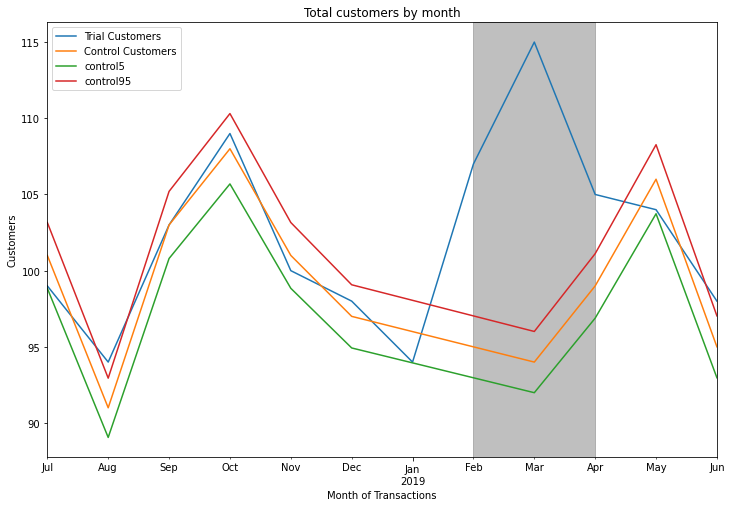

In [ ]:
# Plotting these in one nice graph
pd.DataFrame(combinedCustomer).plot(figsize=(12,8))
plt.xlabel('Month of Transactions')
plt.ylabel('Customers')
plt.title('Total customers by month')
plt.axvspan('2019-02', '2019-04', color='grey', alpha=0.5)
plt.show()

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

# Selecting control store for trial store 88

In [ ]:
# Compute correlation with trial store 88
trial_store = 88
corr_nSales = calculateCorrelation(pretrialmeasures, 'Total_sales', trial_store)
corr_nCustomers = calculateCorrelation(pretrialmeasures, 'nCustomers', trial_store)

# Compute magnitude with trial store 88
magnitude_nSales = calculateMagnitudeDistance(pretrialmeasures, 'Total_sales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(pretrialmeasures, 'nCustomers', trial_store)


In [ ]:
corr_nSales.head()

,Store1,Store2,Correlation
0,88.0,1.0,0.813636
1,88.0,2.0,-0.067927
2,88.0,3.0,-0.507847
3,88.0,4.0,-0.745566
4,88.0,5.0,0.190330


In [ ]:
magnitude_nSales.head()

,Store1,Store2,Magnitude
0,88.0,1.0,0.548959
1,88.0,2.0,0.541212
2,88.0,3.0,0.458109
3,88.0,4.0,0.484447
4,88.0,5.0,0.496409


In [ ]:
# Concatenate the scores together for 'nSales'
score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)
score_nSales.head()

,Store1,Store2,Correlation,Magnitude
0,88.0,1.0,0.813636,0.548959
1,88.0,2.0,-0.067927,0.541212
2,88.0,3.0,-0.507847,0.458109
3,88.0,4.0,-0.745566,0.484447
4,88.0,5.0,0.190330,0.496409


In [ ]:
# Calculate weighted average
corr_weight = 0.5
score_nSales['scoreNSales'] = corr_weight * score_nSales['Correlation'] + (1 - corr_weight) * score_nSales['Magnitude']
score_nSales.head()

,Store1,Store2,Correlation,Magnitude,scoreNSales
0,88.0,1.0,0.813636,0.548959,0.681297
1,88.0,2.0,-0.067927,0.541212,0.236643
2,88.0,3.0,-0.507847,0.458109,-0.024869
3,88.0,4.0,-0.745566,0.484447,-0.130559
4,88.0,5.0,0.190330,0.496409,0.343370


In [ ]:
# Same for customers
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)
score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['Correlation'] + (1 - corr_weight) * score_nCustomers['Magnitude']
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude,scoreNCust
0,88.0,1.0,0.305334,0.357143,0.331238
1,88.0,2.0,-0.452379,0.285714,-0.083332
2,88.0,3.0,0.522884,0.683673,0.603279
3,88.0,4.0,-0.361503,0.577922,0.108210
4,88.0,5.0,-0.025320,0.558442,0.266561


In [ ]:
# index both the new dataframes
score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)

In [ ]:
# Calculate average of 'scoreNSales' and 'scoreNCust' in new dataframe
score_Control = pd.concat([score_nSales['scoreNSales'], score_nCustomers['scoreNCust']], axis = 1)
score_Control['finalControlScore'] = 0.5 * (score_Control['scoreNSales'] + score_Control['scoreNCust'])
score_Control.head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
88.0   1.0        0.681297    0.331238           0.506268
       2.0        0.236643   -0.083332           0.076655
       3.0       -0.024869    0.603279           0.289205
       4.0       -0.130559    0.108210          -0.011175
       5.0        0.343370    0.266561           0.304965

In [ ]:
# Top 5 stores with highest 'finalControlScore'
score_Control.sort_values(by = 'finalControlScore', ascending = False).head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
88.0   178.0      0.650803    0.707828           0.679316
       14.0       0.646064    0.685774           0.665919
       134.0      0.775084    0.540154           0.657619
       237.0      0.451974    0.777235           0.614604
       187.0      0.616752    0.594560           0.605656

After doing some visualisations, found that stores 178, 14 and 134 do not match trial store so set store 237 as control store


In [ ]:
control_store = 237

In [ ]:
pastSales = pretrialmeasures

In [ ]:
# Create a new column for store type
store_type = []

for i in pastSales['STORE_NBR']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i == control_store:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,store_type,transactionMonth
0,1,201807,206.9,49,1.061224,3.337097,1.192308,Other Stores,2018-07
1,1,201808,176.1,42,1.023810,3.261111,1.255814,Other Stores,2018-08
2,1,201809,278.8,59,1.050847,3.717333,1.209677,Other Stores,2018-09
3,1,201810,188.1,44,1.022727,3.243103,1.288889,Other Stores,2018-10
4,1,201811,192.6,46,1.021739,3.378947,1.212766,Other Stores,2018-11


In [ ]:
# Create a new column 'TransactionMonth'

pastSales['transactionMonth'] = pd.to_datetime(pastSales['Month_id'].astype(str), format = '%Y%m')
pastSales.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,store_type,transactionMonth
0,1,201807,206.9,49,1.061224,3.337097,1.192308,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,3.261111,1.255814,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,3.717333,1.209677,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,3.243103,1.288889,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,3.378947,1.212766,Other Stores,2018-11-01


Visualisation for control store, trial store and other stores

---

---








In [ ]:
controlSalesPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['transactionMonth', 'Total_sales']]
controlSalesPlot.set_index('transactionMonth', inplace = True)
controlSalesPlot.rename(columns = {'Total_sales': 'Control Store'}, inplace = True)
trialSalesPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['transactionMonth', 'Total_sales']]
trialSalesPlot.set_index('transactionMonth', inplace = True)
trialSalesPlot.rename(columns = {'Total_sales': 'Trial Store'}, inplace = True)
otherSalesPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['transactionMonth', 'Total_sales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('transactionMonth').Total_sales.mean())
otherSalesPlot.rename(columns = {'Total_sales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([controlSalesPlot, trialSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Control Store,Trial Store,Other Stores
transactionMonth,,,
2018-07-01,1448.4,1310.0,629.590310
2018-08-01,1367.8,1323.8,601.889341
2018-09-01,1322.2,1423.0,611.317054
2018-10-01,1348.3,1352.4,626.359302
2018-11-01,1397.6,1382.8,609.858527
2018-12-01,1265.0,1325.2,640.534884
2019-01-01,1219.7,1266.4,620.528682


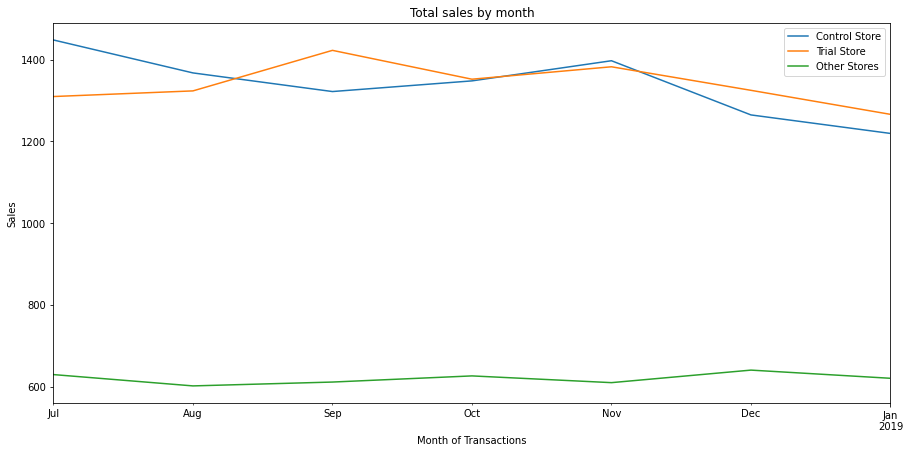

In [ ]:
# Plotting these in one nice graph
pd.DataFrame(combineSalesPlot).plot(figsize=(15,7))
plt.xlabel('Month of Transactions')
plt.ylabel('Sales')
plt.title('Total sales by month')
plt.axvspan('2019-02', '2019-04', color='grey', alpha=0.5)
plt.show()

In [ ]:
# Visualisation for customers
controlCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['transactionMonth', 'nCustomers']]
controlCustomersPlot.set_index('transactionMonth', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)
trialCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['transactionMonth', 'nCustomers']]
trialCustomersPlot.set_index('transactionMonth', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)
otherCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['transactionMonth', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('transactionMonth').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([controlCustomersPlot, trialCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Control Store,Trial Store,Other Stores
transactionMonth,,,
2018-07-01,128,129,71.732558
2018-08-01,135,131,71.457364
2018-09-01,126,124,69.488372
2018-10-01,123,123,70.934109
2018-11-01,132,130,69.833333
2018-12-01,124,126,72.906977
2019-01-01,117,117,70.604651


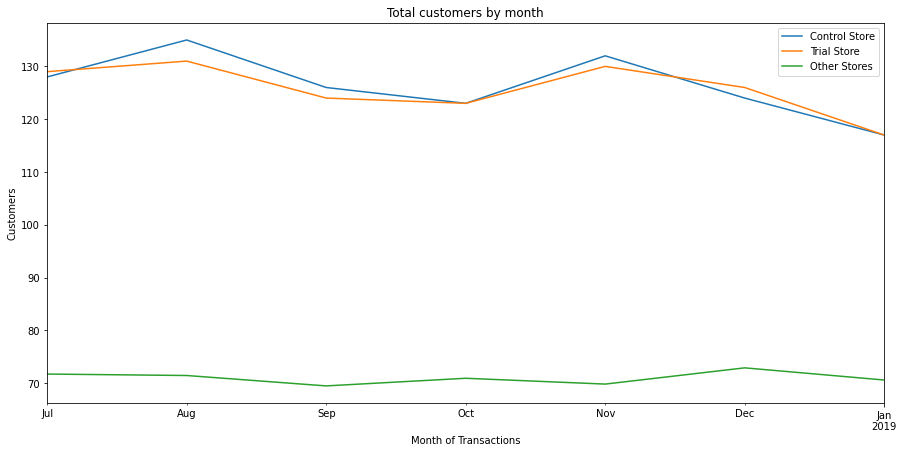

In [ ]:
# Plotting these in one nice graph
pd.DataFrame(combineCustomersPlot).plot(figsize=(15,7))
plt.xlabel('Month of Transactions')
plt.ylabel('Customers')
plt.title('Total customers by month')
plt.axvspan('2019-02', '2019-04', color='grey', alpha=0.5)
plt.show()

# Assessment for trial store 88

In [ ]:
# Calculate scaling factor
trial_sum = pretrialmeasures.loc[pretrialmeasures['store_type'] == 'Trial Store' , 'Total_sales'].sum()
control_sum = pretrialmeasures.loc[pretrialmeasures['store_type'] == 'Control Store', 'Total_sales'].sum()
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

1.001558330664959

In [ ]:
scaledControlSales = df_ot
scaledControlSales.head()

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,transactionMonth
0,1,201807,206.9,49,1.061224,3.337097,1.192308,2018-07
1,1,201808,176.1,42,1.023810,3.261111,1.255814,2018-08
2,1,201809,278.8,59,1.050847,3.717333,1.209677,2018-09
3,1,201810,188.1,44,1.022727,3.243103,1.288889,2018-10
4,1,201811,192.6,46,1.021739,3.378947,1.212766,2018-11


In [ ]:
# filter the dataframe to stores with number 237
scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR'] == control_store]
scaledControlSales

,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,transactionMonth
2747,237,201807,1448.4,128,1.265625,4.470370,2.000000,2018-07
2748,237,201808,1367.8,135,1.222222,4.369968,1.896970,2018-08
2749,237,201809,1322.2,126,1.182540,4.422074,2.006711,2018-09
2750,237,201810,1348.3,123,1.195122,4.509365,2.034014,2018-10
2751,237,201811,1397.6,132,1.219697,4.367500,1.987578,2018-11
2752,237,201812,1265.0,124,1.161290,4.377163,2.006944,2018-12
2753,237,201901,1219.7,117,1.188034,4.403249,1.992806,2019-01
2754,237,201902,1404.8,126,1.246032,4.473885,2.000000,2019-02
2755,237,201903,1208.2,119,1.126050,4.409489,2.044776,2019-03
2756,237,201904,1204.6,120,1.125000,4.428676,2.014815,2019-04


In [ ]:
# Create 'controlSales' which applies 'scalingFactorSales' to 'totSales' column
scaledControlSales['controlSales'] = scaledControlSales['Total_sales'] * scalingFactorSales
scaledControlSales.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,transactionMonth,controlSales
2747,237,201807,1448.4,128,1.265625,4.470370,2.000000,2018-07,1450.657086
2748,237,201808,1367.8,135,1.222222,4.369968,1.896970,2018-08,1369.931485
2749,237,201809,1322.2,126,1.182540,4.422074,2.006711,2018-09,1324.260425
2750,237,201810,1348.3,123,1.195122,4.509365,2.034014,2018-10,1350.401097
2751,237,201811,1397.6,132,1.219697,4.367500,1.987578,2018-11,1399.777923


In [ ]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlSales[['Month_id', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'Total_sales'
trialSales = df_ot.loc[df_ot['STORE_NBR'] == trial_store, 'Total_sales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'Total_sales': 'trialSales'}, inplace = True)

percentageDiff

,Month_id,controlSales,trialSales
0,201807,1450.657086,1310.00
1,201808,1369.931485,1323.80
2,201809,1324.260425,1423.00
3,201810,1350.401097,1352.40
4,201811,1399.777923,1382.80
5,201812,1266.971288,1325.20
6,201901,1221.600696,1266.40
7,201902,1406.989143,1370.20
8,201903,1210.082775,1477.20
9,201904,1206.477165,1439.40


In [ ]:
# Calculate percentage difference 
percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales) / percentageDiff.controlSales
percentageDiff

,Month_id,controlSales,trialSales,percentageDiff
0,201807,1450.657086,1310.00,0.096961
1,201808,1369.931485,1323.80,0.033674
2,201809,1324.260425,1423.00,0.074562
3,201810,1350.401097,1352.40,0.001480
4,201811,1399.777923,1382.80,0.012129
5,201812,1266.971288,1325.20,0.045959
6,201901,1221.600696,1266.40,0.036673
7,201902,1406.989143,1370.20,0.026147
8,201903,1210.082775,1477.20,0.220743
9,201904,1206.477165,1439.40,0.193060


In [ ]:
# Our null hypothesis is that the trial period is the same as the pre-trial period
# Calculate the standard deviation
stdDev = stdev(percentageDiff.loc[percentageDiff['Month_id'] < 201902, 'percentageDiff'])
stdDev

0.033467867303078776

In [ ]:
dof = 7

In [ ]:
# Calculate 'tValue'
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['Month_id'] > 201901) & (percentageDiff['Month_id'] < 201905), 'tValue']

7    0.781270
8    6.595668
9    5.768527
Name: tValue, dtype: float64

In [ ]:
# Find the 95th percentile of the t distribution with dof = 7
t.isf(0.05, dof)

1.8945786050613054

In [ ]:
# Add a new column 'transactionMonth' to 'scaledControlSales'
scaledControlSales['transactionMonth'] = pd.to_datetime(scaledControlSales['Month_id'].astype(str), format = '%Y%m')
scaledControlSales

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,transactionMonth,controlSales
2747,237,201807,1448.4,128,1.265625,4.470370,2.000000,2018-07-01,1450.657086
2748,237,201808,1367.8,135,1.222222,4.369968,1.896970,2018-08-01,1369.931485
2749,237,201809,1322.2,126,1.182540,4.422074,2.006711,2018-09-01,1324.260425
2750,237,201810,1348.3,123,1.195122,4.509365,2.034014,2018-10-01,1350.401097
2751,237,201811,1397.6,132,1.219697,4.367500,1.987578,2018-11-01,1399.777923
2752,237,201812,1265.0,124,1.161290,4.377163,2.006944,2018-12-01,1266.971288
2753,237,201901,1219.7,117,1.188034,4.403249,1.992806,2019-01-01,1221.600696
2754,237,201902,1404.8,126,1.246032,4.473885,2.000000,2019-02-01,1406.989143
2755,237,201903,1208.2,119,1.126050,4.409489,2.044776,2019-03-01,1210.082775
2756,237,201904,1204.6,120,1.125000,4.428676,2.014815,2019-04-01,1206.477165


Visualisations

---

---







In [ ]:
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store 
controlSales = scaledControlSales.loc[:, ['transactionMonth', 'controlSales']]
controlSales.set_index('transactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales

,Control Sales
transactionMonth,
2018-07-01,1450.657086
2018-08-01,1369.931485
2018-09-01,1324.260425
2018-10-01,1350.401097
2018-11-01,1399.777923
2018-12-01,1266.971288
2019-01-01,1221.600696
2019-02-01,1406.989143
2019-03-01,1210.082775


In [ ]:
# Create a new column 'TransationMonth' under 'df_ot' dataframe
df_ot['transactionMonth'] = pd.to_datetime(df_ot['Month_id'].astype(str), format = '%Y%m')

# Extract 'Total-sales' for trial store from 'df_ot'
trialSales = df_ot.loc[df_ot['STORE_NBR'] == trial_store, ['transactionMonth', 'Total_sales']]
trialSales.set_index('transactionMonth', inplace = True)
trialSales.rename(columns = {'Total_sales': 'Trial Sales'}, inplace = True)
trialSales

,Trial Sales
transactionMonth,
2018-07-01,1310.00
2018-08-01,1323.80
2018-09-01,1423.00
2018-10-01,1352.40
2018-11-01,1382.80
2018-12-01,1325.20
2019-01-01,1266.40
2019-02-01,1370.20
2019-03-01,1477.20


In [ ]:
controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)
controlSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval
transactionMonth,,,
2018-07-01,1450.657086,1353.556288,1547.757884
2018-08-01,1369.931485,1278.234114,1461.628855
2018-09-01,1324.260425,1235.620080,1412.900769
2018-10-01,1350.401097,1260.011008,1440.791187
2018-11-01,1399.777923,1306.082759,1493.473086
2018-12-01,1266.971288,1182.165634,1351.776942
2019-01-01,1221.600696,1139.831956,1303.369436
2019-02-01,1406.989143,1312.811291,1501.166995
2019-03-01,1210.082775,1129.084996,1291.080555


In [ ]:
# Merge the two dataframes together 'controlSales' and 'trialSales'
combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
transactionMonth,,,,
2018-07-01,1450.657086,1353.556288,1547.757884,1310.00
2018-08-01,1369.931485,1278.234114,1461.628855,1323.80
2018-09-01,1324.260425,1235.620080,1412.900769,1423.00
2018-10-01,1350.401097,1260.011008,1440.791187,1352.40
2018-11-01,1399.777923,1306.082759,1493.473086,1382.80
2018-12-01,1266.971288,1182.165634,1351.776942,1325.20
2019-01-01,1221.600696,1139.831956,1303.369436,1266.40
2019-02-01,1406.989143,1312.811291,1501.166995,1370.20
2019-03-01,1210.082775,1129.084996,1291.080555,1477.20


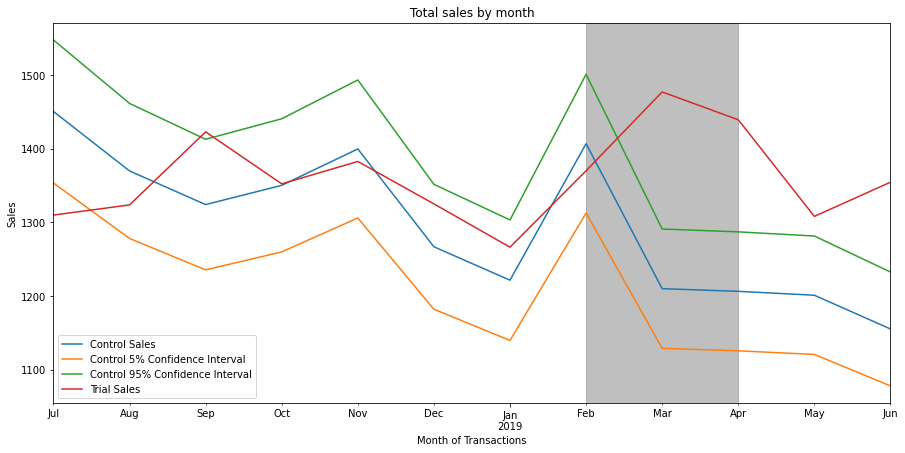

In [ ]:
# Plotting these in one nice graph
pd.DataFrame(combineSales).plot(figsize=(15,7))
plt.xlabel('Month of Transactions')
plt.ylabel('Sales')
plt.title('Total sales by month')
plt.axvspan('2019-02', '2019-04', color='grey', alpha=0.5)
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

In [ ]:
# Same for customers

# Compute scaling factor
trial_customers = pretrialmeasures.loc[pretrialmeasures['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = pretrialmeasures.loc[pretrialmeasures['store_type'] == 'Control Store', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

0.9943502824858758

In [ ]:
scaledControlCustomers = df_ot
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == control_store]
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,STORE_NBR,Month_id,Total_sales,nCustomers,nTxn_per_cust,Avg_ppu,nChips_per_Txn,transactionMonth,controlCustomers
2747,237,201807,1448.4,128,1.265625,4.470370,2.000000,2018-07-01,127.276836
2748,237,201808,1367.8,135,1.222222,4.369968,1.896970,2018-08-01,134.237288
2749,237,201809,1322.2,126,1.182540,4.422074,2.006711,2018-09-01,125.288136
2750,237,201810,1348.3,123,1.195122,4.509365,2.034014,2018-10-01,122.305085
2751,237,201811,1397.6,132,1.219697,4.367500,1.987578,2018-11-01,131.254237


In [ ]:
percentageDiff = scaledControlCustomers[['Month_id', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = df_ot.loc[df_ot['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,Month_id,controlCustomers,trialCustomers
0,201807,127.276836,129
1,201808,134.237288,131
2,201809,125.288136,124
3,201810,122.305085,123
4,201811,131.254237,130
5,201812,123.299435,126
6,201901,116.338983,117
7,201902,125.288136,124
8,201903,118.327684,134
9,201904,119.322034,128


In [ ]:
# Calculate percentage difference
percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,Month_id,controlCustomers,trialCustomers,percentageDiff
0,201807,127.276836,129,0.013539
1,201808,134.237288,131,0.024116
2,201809,125.288136,124,0.010281
3,201810,122.305085,123,0.005682
4,201811,131.254237,130,0.009556
5,201812,123.299435,126,0.021902
6,201901,116.338983,117,0.005682
7,201902,125.288136,124,0.010281
8,201903,118.327684,134,0.132448
9,201904,119.322034,128,0.072727


In [ ]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Find standard deviation
stdDev = stdev(percentageDiff.loc[percentageDiff['Month_id'] < 201902, 'percentageDiff'])
stdDev

0.00741024435207507

In [ ]:
dof = 7

In [ ]:
# Calculate 'tValue'
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['Month_id'] > 201901) & (percentageDiff['Month_id'] < 201905), 'tValue']

7     1.387456
8    17.873693
9     9.814423
Name: tValue, dtype: float64

In [ ]:
# Find the 95th percentile of the t distribution with dof = 7
t.isf(0.05, dof)

1.8945786050613054

We can see that the t-value is larger than the 95th percentile value of the t-distribution

---

---
Visualisation





In [ ]:
controlCustomers = scaledControlCustomers.loc[:, ['transactionMonth', 'controlCustomers']]
controlCustomers.set_index('transactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

trialCustomers = df_ot.loc[df_ot['STORE_NBR'] == trial_store, ['transactionMonth', 'nCustomers']]
trialCustomers.set_index('transactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
transactionMonth,
2018-07-01,129
2018-08-01,131
2018-09-01,124
2018-10-01,123
2018-11-01,130
2018-12-01,126
2019-01-01,117
2019-02-01,124
2019-03-01,134


In [ ]:
# Create two new columns in 'controlCustomers' which calculates the 5% and 95% confidence interval
controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers'] * (1 - stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers'] * (1 + stdDev*2)
controlCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval
transactionMonth,,,
2018-07-01,127.276836,125.390531,129.163141
2018-08-01,134.237288,132.247826,136.226750
2018-09-01,125.288136,123.431304,127.144967
2018-10-01,122.305085,120.492464,124.117706
2018-11-01,131.254237,129.308985,133.199489
2018-12-01,123.299435,121.472077,125.126793
2019-01-01,116.338983,114.614782,118.063184
2019-02-01,125.288136,123.431304,127.144967
2019-03-01,118.327684,116.574010,120.081358


In [ ]:
# Merge the two dataframes together 'controlSales' and 'trialSales'
combineCustomers = pd.merge(controlCustomers, trialCustomers, left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
transactionMonth,,,,
2018-07-01,127.276836,125.390531,129.163141,129
2018-08-01,134.237288,132.247826,136.226750,131
2018-09-01,125.288136,123.431304,127.144967,124
2018-10-01,122.305085,120.492464,124.117706,123
2018-11-01,131.254237,129.308985,133.199489,130
2018-12-01,123.299435,121.472077,125.126793,126
2019-01-01,116.338983,114.614782,118.063184,117
2019-02-01,125.288136,123.431304,127.144967,124
2019-03-01,118.327684,116.574010,120.081358,134


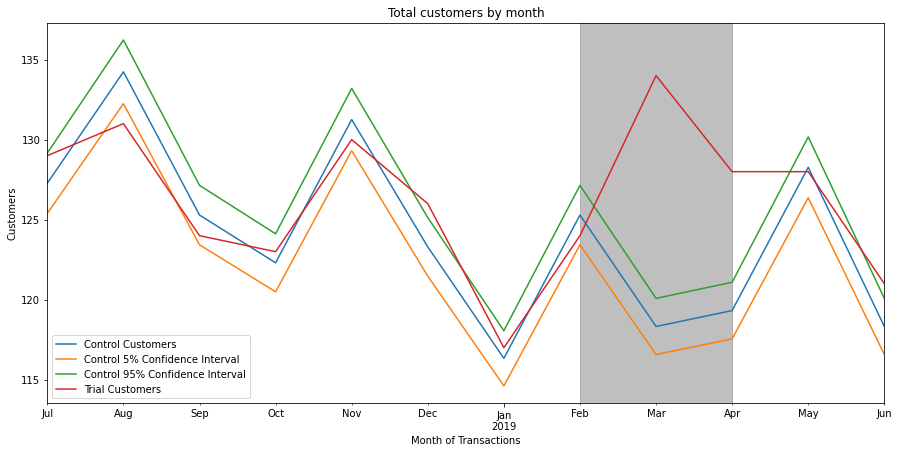

In [ ]:
# Plotting these in one nice graph
pd.DataFrame(combineCustomers).plot(figsize=(15,7))
plt.xlabel('Month of Transactions')
plt.ylabel('Customers')
plt.title('Total customers by month')
plt.axvspan('2019-02', '2019-04', color='grey', alpha=0.5)
plt.show()

Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.



# Conclusion

We've found control stores 233, 155, 237 for trial stores 77, 86 and 88
respectively. The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.